In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/552_crop6.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/267_crop16.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/50_crop12.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/405_crop11.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/598_crop9.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/435_crop2.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/435_crop14.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/373_crop8.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/175_crop13.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/107_crop6.png
/kaggle/input/major-final-kymograms-cropped/final kymograms croppe

In [8]:
from pathlib import Path
import shutil, os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

src_dir = Path("/kaggle/input/major-final-kymograms-cropped/final kymograms cropped")
dst_dir = Path("/kaggle/working/binary_split")

# Step 1: Map 3-class labels to binary
label_map = {
    'healthy': 'healthy',
    'functional': 'unhealthy',
    'organic': 'unhealthy'
}

# Step 2: Load and label all images
all_images = []
for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    if cls_dir.is_dir():
        mapped_label = label_map[cls]
        for img_path in cls_dir.glob("*.png"):
            all_images.append((img_path, mapped_label))

# Step 3: Split 15% test set
labels = [label for _, label in all_images]
trainval, test = train_test_split(all_images, test_size=0.15, stratify=labels, random_state=42)

# Step 4: Split 85% trainval into 70/15 split (82.35% train and 17.65% val of trainval)
trainval_labels = [label for _, label in trainval]
train, val = train_test_split(trainval, test_size=0.1765, stratify=trainval_labels, random_state=42)

# Step 5: Copy to new directory
def copy_images(data, split_name):
    for img_path, label in data:
        dest_dir = dst_dir / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, dest_dir / img_path.name)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"✅ Data split complete:\n- Train: {len(train)}\n- Validation: {len(val)}\n- Test: {len(test)}")

# Step 6: Oversample to balance training set
train_dir = dst_dir / "train"
class_images = defaultdict(list)

for cls in os.listdir(train_dir):
    cls_path = train_dir / cls
    class_images[cls] = list(cls_path.glob("*.png"))

# Determine max class count
target_count = max(len(images) for images in class_images.values())

# Oversample
for cls, images in class_images.items():
    if len(images) < target_count:
        to_add = random.choices(images, k=target_count - len(images))
        for i, img_path in enumerate(to_add):
            new_name = img_path.stem + f"_dup{i}" + img_path.suffix
            shutil.copy(img_path, img_path.parent / new_name)

print(f"✅ Training set balanced using random oversampling (~{target_count} per class)")

✅ Data split complete:
- Train: 6926
- Validation: 1485
- Test: 1485
✅ Training set balanced using random oversampling (~4353 per class)


In [9]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Define base path
base_path = Path("/kaggle/working/binary_split")

# Transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet-152
resnet = models.resnet152(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove classifier layer
resnet.eval()

# Function to extract features
def extract_features(data_path, save_prefix):
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc=f"Extracting from {save_prefix}"):
            output = resnet(inputs)
            features.append(output)
            labels.append(targets)

    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    np.save(f"/kaggle/working/{save_prefix}_features.npy", features)
    np.save(f"/kaggle/working/{save_prefix}_labels.npy", labels)

# Extract features for train, val, and test
extract_features(base_path / "train", "train")
extract_features(base_path / "val", "val")
extract_features(base_path / "test", "test")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting from test: 100%|██████████| 47/47 [07:27<00:00,  9.52s/it]


In [10]:
# Loading extracted features and labels for train, validation, and test
train_features = np.load("/kaggle/working/train_features.npy")
train_labels = np.load("/kaggle/working/train_labels.npy")
val_features = np.load("/kaggle/working/val_features.npy")
val_labels = np.load("/kaggle/working/val_labels.npy")
test_features = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

# Convert features to torch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoader
batch_size = 32

train_data = torch.utils.data.TensorDataset(train_features, train_labels)
val_data = torch.utils.data.TensorDataset(val_features, val_labels)
test_data = torch.utils.data.TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Epoch 1/30 | Train Loss: 0.3500, Train Acc: 0.8540 | Val Loss: 0.2050, Val Acc: 0.9320
Epoch 2/30 | Train Loss: 0.1191, Train Acc: 0.9630 | Val Loss: 0.0720, Val Acc: 0.9845
Epoch 3/30 | Train Loss: 0.0678, Train Acc: 0.9813 | Val Loss: 0.0818, Val Acc: 0.9731
Epoch 4/30 | Train Loss: 0.0486, Train Acc: 0.9873 | Val Loss: 0.0590, Val Acc: 0.9798
Epoch 5/30 | Train Loss: 0.0409, Train Acc: 0.9875 | Val Loss: 0.0293, Val Acc: 0.9926
Epoch 6/30 | Train Loss: 0.0280, Train Acc: 0.9916 | Val Loss: 0.0553, Val Acc: 0.9744
Epoch 7/30 | Train Loss: 0.0381, Train Acc: 0.9905 | Val Loss: 0.0272, Val Acc: 0.9899
Epoch 8/30 | Train Loss: 0.0135, Train Acc: 0.9972 | Val Loss: 0.0213, Val Acc: 0.9946
Epoch 9/30 | Train Loss: 0.0307, Train Acc: 0.9938 | Val Loss: 0.0869, Val Acc: 0.9630
Epoch 10/30 | Train Loss: 0.0386, Train Acc: 0.9870 | Val Loss: 0.0216, Val Acc: 0.9919
Epoch 11/30 | Train Loss: 0.0147, Train Acc: 0.9949 | Val Loss: 0.0493, Val Acc: 0.9859
Epoch 12/30 | Train Loss: 0.0132, Train A

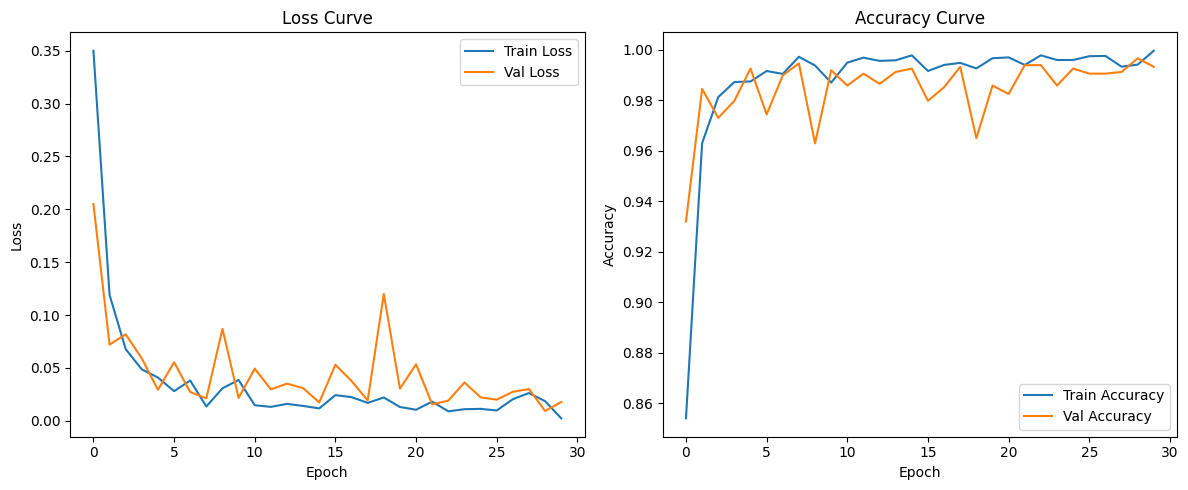

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define binary classification model (ResNet50V2-inspired MLP)
class ResNet50V2MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=512):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.shortcut = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.bn2(self.fc2(x)) + residual
        x = self.relu(x)
        return self.out(x).squeeze(1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
input_dim = train_features.shape[1]
model = ResNet50V2MLP(input_dim=input_dim).to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Prepare dataloaders
batch_size = 32
train_loader = DataLoader(TensorDataset(train_features, train_labels.float()), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_features, val_labels.float()), batch_size=batch_size)

# Initialize history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Training loop
def train_model(model, epochs=30):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            train_correct += (preds == y_batch.bool()).sum().item()
            total_train += y_batch.size(0)

        train_loss /= len(train_loader)
        train_acc = train_correct / total_train

        # Validation loop
        model.eval()
        val_loss, val_correct = 0.0, 0
        total_val = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == y_batch.bool()).sum().item()
                total_val += y_batch.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / total_val

        # Save to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Train the model
train_model(model, epochs=30)

# Save model
torch.save(model.state_dict(), "resnet50v2_binary_classifier.pth")

# Plot training curves
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)



Validation Performance of Binary ResNet50V2-MLP Classifier
Metrics             Value
----------------------------------------
Healthy
F1 Score (%)           99.47
Precision (%)          99.04
Recall (%)             99.89
Sensitivity (%)        99.89
Specificity (%)        98.37
----------------------------------------
Unhealthy
F1 Score (%)           99.09
Precision (%)          99.82
Recall (%)             98.37
Sensitivity (%)        98.37
Specificity (%)        99.89
----------------------------------------
Overall Accuracy (%)   99.33


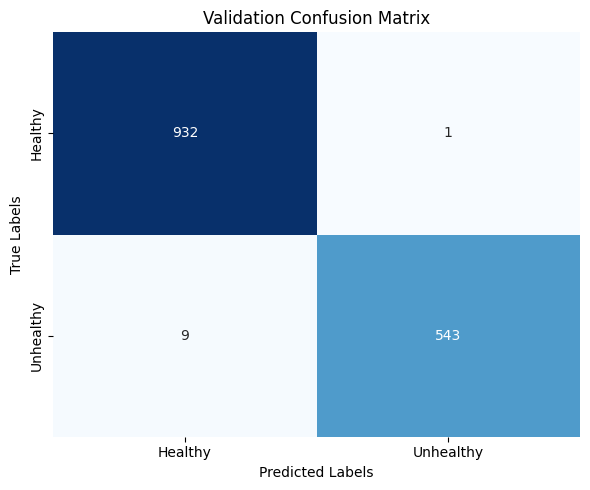

In [12]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
model.eval()

val_y_true = []
val_y_pred = []
val_y_probs = []

# Predict on validation data
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        outputs = model(val_x)
        probs = torch.sigmoid(outputs)  # For BCEWithLogitsLoss

        preds = probs > 0.5  # Binary classification threshold

        val_y_true.extend(val_y.cpu().numpy())
        val_y_pred.extend(preds.cpu().numpy())
        val_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
val_y_true = np.array(val_y_true)
val_y_pred = np.array(val_y_pred).astype(int)
val_y_probs = np.array(val_y_probs)

# Class names
class_names = ['Healthy', 'Unhealthy']
n_classes = len(class_names)

# AUC Score
val_auc = roc_auc_score(val_y_true, val_y_probs) * 100

# Classification report
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
val_conf_matrix = confusion_matrix(val_y_true, val_y_pred)

# Sensitivity and Specificity
val_sensitivity = []
val_specificity = []

for i in range(n_classes):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    val_sensitivity.append(sensitivity)
    val_specificity.append(specificity)

# Accuracy
val_acc = accuracy_score(val_y_true, val_y_pred) * 100

# Print Validation Report
print("\nValidation Performance of Binary ResNet50V2-MLP Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{val_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{val_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{val_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{val_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{val_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{val_acc:>8.2f}")


# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



Test Performance of Binary ResNet50V2-MLP Classifier
Metrics             Value
----------------------------------------
Healthy
F1 Score (%)           99.63
Precision (%)          99.47
Recall (%)             99.79
Sensitivity (%)        99.79
Specificity (%)        99.09
----------------------------------------
Unhealthy
F1 Score (%)           99.36
Precision (%)          99.64
Recall (%)             99.09
Sensitivity (%)        99.09
Specificity (%)        99.79
----------------------------------------
Overall Accuracy (%)   99.53


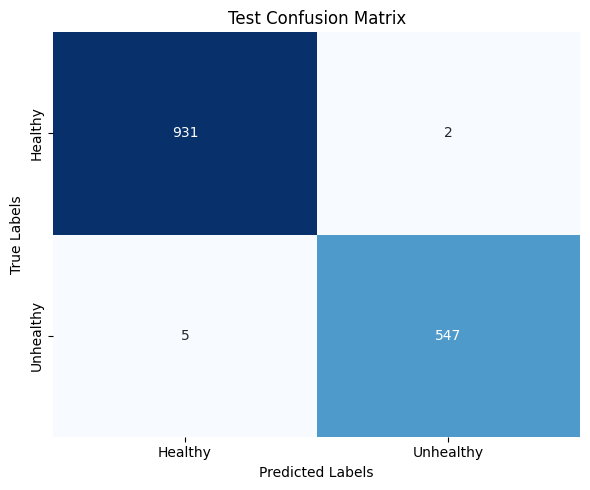

In [13]:
# Set the model to evaluation mode
model.eval()

test_y_true = []
test_y_pred = []
test_y_probs = []

# Predict on test data
with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        outputs = model(test_x)
        probs = torch.sigmoid(outputs)  # For BCEWithLogitsLoss

        preds = probs > 0.5  # Binary classification threshold

        test_y_true.extend(test_y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred).astype(int)
test_y_probs = np.array(test_y_probs)

# AUC Score
test_auc = roc_auc_score(test_y_true, test_y_probs) * 100

# Classification report
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
test_conf_matrix = confusion_matrix(test_y_true, test_y_pred)

# Sensitivity and Specificity
test_sensitivity = []
test_specificity = []

for i in range(n_classes):
    TP = test_conf_matrix[i, i]
    FN = test_conf_matrix[i].sum() - TP
    FP = test_conf_matrix[:, i].sum() - TP
    TN = test_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    test_sensitivity.append(sensitivity)
    test_specificity.append(specificity)

# Accuracy
test_acc = accuracy_score(test_y_true, test_y_pred) * 100

# Print Test Report
print("\nTest Performance of Binary ResNet50V2-MLP Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{test_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{test_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{test_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{test_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{test_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{test_acc:>8.2f}")


# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)

plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Create a DataFrame for accuracies
acc_df = pd.DataFrame({
    'Epoch': list(range(1, len(history['train_acc']) + 1)),
    'Train_Accuracy': [acc for acc in history['train_acc']],
    'Val_Accuracy': [acc for acc in history['val_acc']]
})

# Save to CSV
acc_df.to_csv("accuracies_per_epoch.csv", index=False)
print("Saved accuracies to accuracies_per_epoch.csv")


Saved accuracies to accuracies_per_epoch.csv


In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_list = []

# Reload model and evaluate for each epoch if needed,
# but if you stored val logits per epoch during training, use them directly.
# We'll assume you did not store logits — so this computes ROC AUC using val_loader.

model.eval()
with torch.no_grad():
    for epoch in range(len(history['val_acc'])):
        all_preds = []
        all_labels = []

        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(y_batch.numpy())

        # ROC AUC for this epoch
        roc_auc = roc_auc_score(all_labels, all_preds) * 100
        roc_auc_list.append(roc_auc)

# Save ROC AUCs
roc_df = pd.DataFrame({
    'Epoch': list(range(1, len(roc_auc_list) + 1)),
    'Val_ROC_AUC': roc_auc_list
})

roc_df.to_csv("roc_auc_per_epoch.csv", index=False)
print("Saved ROC AUCs to roc_auc_per_epoch.csv")


Saved ROC AUCs to roc_auc_per_epoch.csv
